<a href="https://colab.research.google.com/github/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023/blob/main/feedforward-neural-network/MNielsen_network_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# A module to implement the gradient descent learning algorithm for a feedforward neural network.

import random
import numpy as np

class Network(object):
    
    # the list ''sizes'' contains the number of neurons in the respective layers of the network.
    # [2, 3, 1] input layer 2 neurons, hidden layer 3 neurons, output layer 1 neuron
    def __init__(self, sizes):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
       
    # return the output of the network if "a" is input.
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    # “training_data” is a list of tuples "(x,y)" representing the training inputs and the desired outputs.
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):

        training_data = list(training_data)
        n = len(training_data)
        
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
            
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
            else:
                print("Epoch {} complete".format(j))
                
    # update the network's weights and biases by applying gradient descent 
    # using backpropagation to a single mini batch,i.e., for each mini_batch we apply a single step of gradient descent. 
    # Therefore, to have sufficient update of the weights, it is good to have smaller mini_batch_size.
    # The ''mini_batch'' is a list of tuples "(x,y)", and "eta" is the learning rate.
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) #* \
  #          sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # l=1 means the last layer of the neurons
        # l=2 means the second-last layer
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    # the neural network's output is assumed to be the index of 
    # whichever neuron in the final layer has the highest activation.
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)),y)
                       for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_results)
    
    # vector of partial derivatives \partial C_X / \partial a for the output activations.
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
# Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
    
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

**Therefore, to have sufficient update of the weights, it is good to have smaller mini_batch_size**.

In [11]:
neural_network = Network([2,3,2,1])
# show the random biases
neural_network.biases

[array([[-0.64883298],
        [ 0.68715592],
        [ 0.84538644]]),
 array([[-0.94010424],
        [-0.89888091]]),
 array([[-1.01602062]])]

In [12]:
# show the random weights
neural_network.weights

[array([[-0.04009933, -1.36815578],
        [ 0.34424685,  0.40958709],
        [-0.6769856 ,  0.78388171]]),
 array([[-0.04559171, -0.77248103, -2.50906287],
        [ 0.98229804, -0.04901532, -0.60331588]]),
 array([[-0.46938197, -0.12047035]])]

In [13]:
!git clone https://github.com/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023

fatal: destination path 'PHYS3151-Machine-Learning-in-Physics-2023' already exists and is not an empty directory.


In [14]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('/content/PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[4999].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

# Return a 10-dimensional unit vector with a 1.0 in the jth position and zeros elsewhere.
# This is used to convert a digit (0...9) into a corresponding desired output from the neural network.
def vectorized_result(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e    

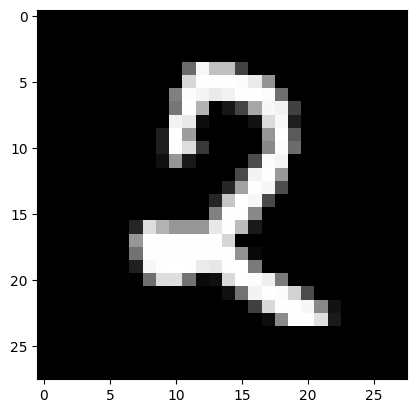

In [15]:
training_data, validation_data, test_data = load_data_wrapper()


In [16]:
net = Network([784,30,10])

In [17]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)     

Epoch 0 : 8944 / 10000
Epoch 1 : 9085 / 10000
Epoch 2 : 9214 / 10000
Epoch 3 : 9235 / 10000
Epoch 4 : 9325 / 10000
Epoch 5 : 9235 / 10000
Epoch 6 : 9305 / 10000
Epoch 7 : 9334 / 10000
Epoch 8 : 9314 / 10000
Epoch 9 : 9381 / 10000
Epoch 10 : 9356 / 10000
Epoch 11 : 9408 / 10000
Epoch 12 : 9410 / 10000
Epoch 13 : 9414 / 10000
Epoch 14 : 9357 / 10000
Epoch 15 : 9470 / 10000
Epoch 16 : 9432 / 10000
Epoch 17 : 9471 / 10000
Epoch 18 : 9459 / 10000
Epoch 19 : 9459 / 10000
Epoch 20 : 9414 / 10000
Epoch 21 : 9443 / 10000
Epoch 22 : 9475 / 10000
Epoch 23 : 9470 / 10000
Epoch 24 : 9339 / 10000
Epoch 25 : 9470 / 10000
Epoch 26 : 9469 / 10000
Epoch 27 : 9469 / 10000
Epoch 28 : 9485 / 10000
Epoch 29 : 9466 / 10000


In [18]:
# An improved version of MNielsen_network, implementing the SGD learning algorithm for a feedforward neural network.
# Improvments include 
# 1. the cross-entropy cost function, 
# 2. regularization, 
# 3. better initialization of the weights.

import json
import random
import sys
import numpy as np

# define the quadratic and cross-entropy cost functions

class QuadraticCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2
    
    # return the error delta from the output layer.
    @staticmethod
    def delta(z, a, y):
        return (a-y)*sigmoid_prime(z)
    
class CrossEntropyCost(object):
    
    # return the cost associated with an output "a" and desired output "y".
    # np.nan_to_num is used to ensure numerical stability, make sure 0*log(0) = 0.0
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    # returm the error delta from the output layer.
    # parameter "z" is not used by the method. 
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
# Main Network class
class Network2(object):
    
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        
        # the biases and weights for the network are initiated randomly, using "self.default_weight_initializer".
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
    
    def default_weight_initializer(self):
        
        # initialize each weight using a Gaussian distribution with mean 0 and standard deviation 1
        # over the square root of the number of weights connecting to the same neuron. 
        # initialize the biases using a Gaussian distribution with mean 0 and standard deviation 1.
    
        # for the input layers, there is no biases.
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
            
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    # "evaluation_data", monitor the cost and accuracy on either the evaluation data or the training data.
    # returns a tuple containing four lists:
    # 1. the (per-epoch) costs on the evaluation data,
    # 2. the accuracies on the evaluation data,
    # 3. the costs on the training data,
    # 4. the accuracies on the training data.
    # If we train for 30 epochs, then the first element of the tuple will be a 
    # 30-element list containing the cost on the evaluation data at the end of each epoch.
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0,
            evaluation_data = None,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            monitor_training_cost = False,
            monitor_training_accuracy = False,
            early_stopping_n = 0):
        
        # early stopping functionality:
        best_accuracy=1
        
        training_data = list(training_data)
        n = len(training_data)
        
        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)
            
        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0
        
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
                
            print("Epoch %s training complete" % j)
            
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
            
            print()
            
            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    print("Early-stopping: Best so far{}".format(best_accuracy))
                else:
                    no_accuracy_change += 1
                    
                if (no_accuracy_change == early_stopping_n):
                    print("Early-stopping: No accuracy cahnge in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
        
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy
    
    
    # "mini_batch" is a list of tuples "(x,y)"
    # "eta" is the learning rate
    # "lmbda" is the regularization parameter
    # "n" is the total size of the training set.
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # "eta*(lmbda/n)*w" comes from the regularization term.
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backpropagate
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    
    def accuracy(self, data, convert=False):
     
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        
        result_accuracy = sum(int(x==y) for (x,y) in results)
        return result_accuracy
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    # Save the neural network to the file "filename".
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        
        
# Loading a Network
def load(filename):
    
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

# Miscellaneous functions
def vectorized_result(j):
    
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))
        
        

In [19]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('/content/PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[1].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

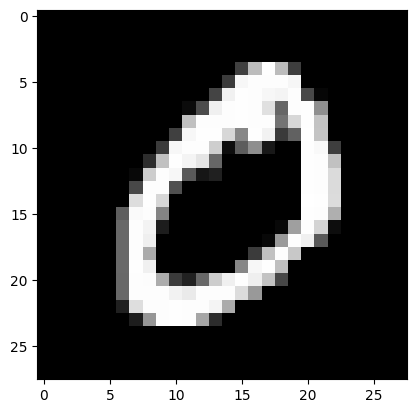

In [20]:
training_data, validation_data, test_data = load_data_wrapper()

In [21]:
net2 = Network2([784, 30, 10], cost=CrossEntropyCost)
net2.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 3884.5414394833842
Accuracy on training data: 47019 / 50000
Cost on evaluation data: 3884.540531377168
Accuracy on evaluation data: 9421 / 10000

Epoch 1 training complete
Cost on training data: 4938.5856859705
Accuracy on training data: 47490 / 50000
Cost on evaluation data: 4938.6073014432595
Accuracy on evaluation data: 9456 / 10000

Epoch 2 training complete
Cost on training data: 5511.923889302634
Accuracy on training data: 47771 / 50000
Cost on evaluation data: 5511.941675429273
Accuracy on evaluation data: 9536 / 10000

Epoch 3 training complete
Cost on training data: 5827.614564138921
Accuracy on training data: 47998 / 50000
Cost on evaluation data: 5827.636434723049
Accuracy on evaluation data: 9561 / 10000

Epoch 4 training complete
Cost on training data: 5998.959112994284
Accuracy on training data: 47944 / 50000
Cost on evaluation data: 5998.992548293421
Accuracy on evaluation data: 9542 / 10000

Epoch 5 training complete
Cost

([3884.540531377168,
  4938.6073014432595,
  5511.941675429273,
  5827.636434723049,
  5998.992548293421,
  6121.021290007689,
  6212.5488510464465,
  6285.7765722451795,
  6367.335653527608,
  6384.349945879155,
  6432.176208839914,
  6422.631482570513,
  6464.716088377129,
  6474.867704035403,
  6488.502664766722,
  6479.171310603353,
  6494.186839070206,
  6515.044413146748,
  6519.533050287879,
  6529.910083585283,
  6564.836382935926,
  6592.796693407825,
  6581.034904013004,
  6589.660671349106,
  6627.94661647375,
  6658.004882263009,
  6645.079809487293,
  6602.655213840593,
  6629.354626339981,
  6666.60727110258],
 [9421,
  9456,
  9536,
  9561,
  9542,
  9565,
  9548,
  9557,
  9528,
  9534,
  9578,
  9622,
  9597,
  9590,
  9577,
  9590,
  9578,
  9618,
  9608,
  9584,
  9575,
  9580,
  9605,
  9592,
  9604,
  9587,
  9614,
  9542,
  9565,
  9601],
 [3884.5414394833842,
  4938.5856859705,
  5511.923889302634,
  5827.614564138921,
  5998.959112994284,
  6120.992095494366,
  

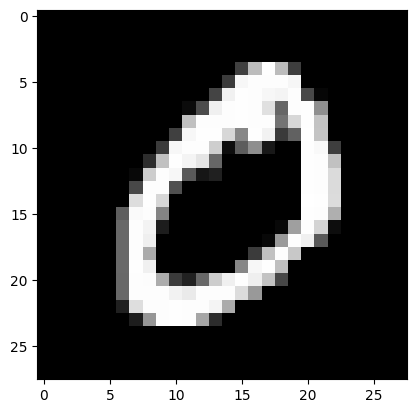

Epoch 0 training complete
Cost on training data: 979.9962913547373
Accuracy on training data: 45858 / 50000
Cost on evaluation data: 979.9895181695631
Accuracy on evaluation data: 9265 / 10000

Epoch 1 training complete
Cost on training data: 1192.9120701184258
Accuracy on training data: 46502 / 50000
Cost on evaluation data: 1192.9076332756356
Accuracy on evaluation data: 9345 / 10000

Epoch 2 training complete
Cost on training data: 1301.1379549852113
Accuracy on training data: 46969 / 50000
Cost on evaluation data: 1301.1348307278129
Accuracy on evaluation data: 9424 / 10000

Epoch 3 training complete
Cost on training data: 1365.9768534882196
Accuracy on training data: 47177 / 50000
Cost on evaluation data: 1365.9737935668495
Accuracy on evaluation data: 9473 / 10000

Epoch 4 training complete
Cost on training data: 1410.3320926285162
Accuracy on training data: 47226 / 50000
Cost on evaluation data: 1410.3295347067851
Accuracy on evaluation data: 9479 / 10000

Epoch 5 training compl

([979.9895181695631,
  1192.9076332756356,
  1301.1348307278129,
  1365.9737935668495,
  1410.3295347067851,
  1435.4573337824231,
  1454.45933973366,
  1466.8744028862056,
  1479.7012418141137,
  1485.1364894322433,
  1492.6134791703694,
  1493.1184890568684,
  1497.2280627510754,
  1500.4098687370072,
  1502.3370051615125,
  1503.8785652926401,
  1506.4488876230419,
  1508.1888634015088,
  1508.3613128277566,
  1508.4805186321892,
  1508.721670745115,
  1509.2632137503992,
  1510.409350947892,
  1513.7437063154014,
  1514.0262147113892,
  1511.2230031369995,
  1512.546077802647,
  1514.1176869296175,
  1516.1636780291653,
  1513.6403264018998],
 [9265,
  9345,
  9424,
  9473,
  9479,
  9504,
  9523,
  9540,
  9565,
  9568,
  9580,
  9557,
  9562,
  9559,
  9551,
  9558,
  9573,
  9571,
  9590,
  9599,
  9568,
  9571,
  9575,
  9589,
  9560,
  9574,
  9576,
  9593,
  9573,
  9599],
 [979.9962913547373,
  1192.9120701184258,
  1301.1379549852113,
  1365.9768534882196,
  1410.3320926285

In [25]:
training_data, validation_data, test_data = load_data_wrapper()
netQuadratic = Network2([784, 30, 10], cost=QuadraticCost)
netQuadratic.SGD(training_data, 30, 10, 0.5,lmbda = 5.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,
        monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)
